In [1]:
# =========================================================
# 1. Mount Google Drive
# =========================================================
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# =========================================================
# 2. Load Dataset
# =========================================================
import pandas as pd

file_path = "/content/drive/MyDrive/Colab Notebooks/MLL/MLL Datasets/data_huang_devansh.csv"  # change path
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
print(df.head())
print(df['Label'].value_counts())


Dataset Shape: (842335, 2)
                                             Content  Label
0  `- This is not ``creative``.  Those are the di...      0
1  `  :: the term ``standard model`` is itself le...      0
2    True or false, the situation as of March 200...      0
3   Next, maybe you could work on being less cond...      0
4               This page will need disambiguation.       0
Label
0    708641
1    133694
Name: count, dtype: int64


In [3]:
# =========================================================
# 3. Data Preprocessing
# =========================================================
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)             # remove links
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)    # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()       # remove extra spaces
    return text

df['clean_text'] = df['Content'].apply(clean_text)
df.head()


,Content,Label,clean_text
0,`- This is not ``creative``. Those are the di...,0,this is not creative those are the dictionary ...
1,` :: the term ``standard model`` is itself le...,0,the term standard model is itself less npov th...
2,"True or false, the situation as of March 200...",0,true or false the situation as of march 2002 w...
3,"Next, maybe you could work on being less cond...",0,next maybe you could work on being less condes...
4,This page will need disambiguation.,0,this page will need disambiguation


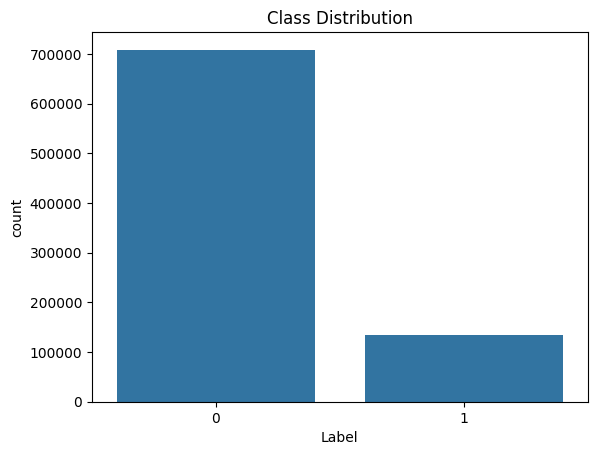

In [8]:
# =========================================================
# 4. EDA Checkpoint
# =========================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution
sns.countplot(x='Label', data=df)
plt.title("Class Distribution")
plt.show()


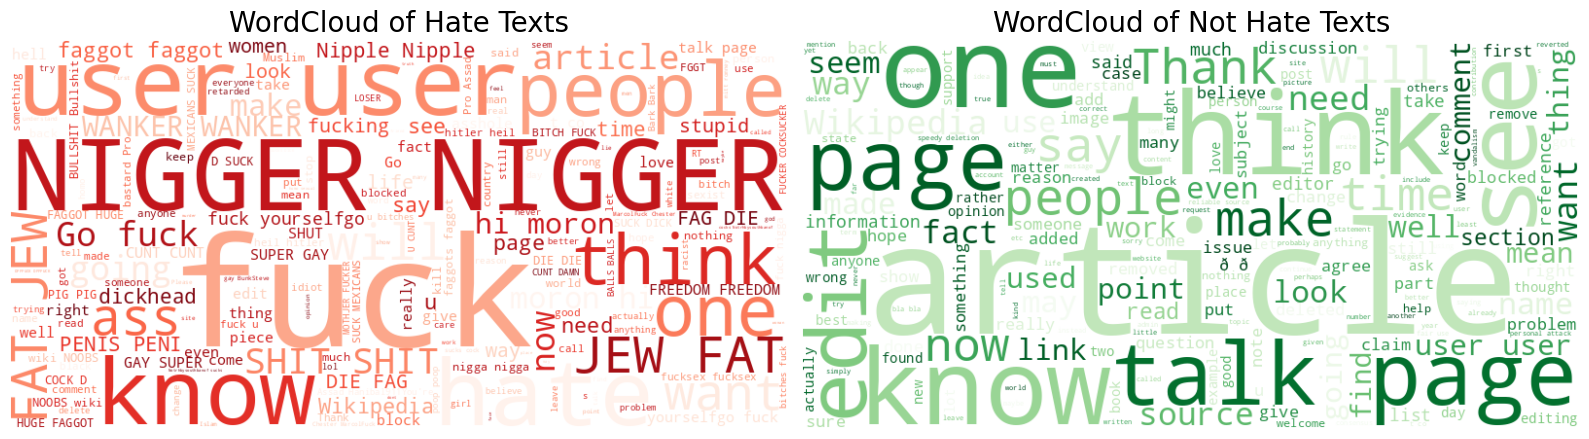

In [39]:
# ==================== WordCloud Visualization ====================
!pip install wordcloud -q

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Separate the classes
hate_texts = df[df['Label']==1]['Content']
not_hate_texts = df[df['Label']==0]['Content']

# Combine all text in each class
hate_text = " ".join(hate_texts.astype(str))
not_hate_text = " ".join(not_hate_texts.astype(str))

# Generate WordClouds
wc_hate = WordCloud(width=800, height=400, background_color='white', colormap='Reds', max_words=200).generate(hate_text)
wc_not_hate = WordCloud(width=800, height=400, background_color='white', colormap='Greens', max_words=200).generate(not_hate_text)

# Plot side-by-side
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(wc_hate, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Hate Texts", fontsize=20)

plt.subplot(1,2,2)
plt.imshow(wc_not_hate, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Not Hate Texts", fontsize=20)

plt.tight_layout()
plt.show()


In [9]:
# =========================================================
# 5. Train-Test Split
# =========================================================
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train:", len(X_train), "Test:", len(X_test))


Train: 673868 Test: 168467


In [10]:

# =========================================================
# 6. TF-IDF Vectorization
# =========================================================
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=200000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF Shape:", X_train_tfidf.shape)


TF-IDF Shape: (673868, 200000)


In [11]:
# ==================== Multinomial Naive Bayes ====================
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

nb_model = MultinomialNB()
print("Training Multinomial Naive Bayes...")
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)
print("Multinomial Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

# Save model
pickle.dump(nb_model, open("/content/naivebayes_hate_model.pkl", "wb"))
print("Multinomial Naive Bayes model saved!")


Training Multinomial Naive Bayes...
Multinomial Naive Bayes Accuracy: 0.8956650263849893
              precision    recall  f1-score   support

           0       0.92      0.96      0.94    141728
           1       0.71      0.57      0.63     26739

    accuracy                           0.90    168467
   macro avg       0.82      0.76      0.79    168467
weighted avg       0.89      0.90      0.89    168467

Confusion Matrix:
 [[135615   6113]
 [ 11464  15275]]
Multinomial Naive Bayes model saved!


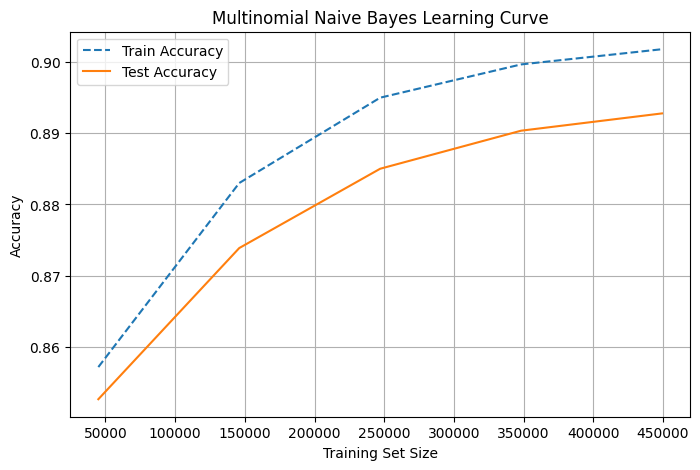

In [12]:
# ==================== Multinomial Naive Bayes Learning Curve ====================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

train_sizes, train_scores, test_scores = learning_curve(
    nb_model, X_train_tfidf, y_train,
    cv=3, train_sizes=np.linspace(0.1,1.0,5), n_jobs=-1, scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, '--', label='Train Accuracy')
plt.plot(train_sizes, test_mean, label='Test Accuracy')
plt.title('Multinomial Naive Bayes Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# ==================== Logistic Regression ====================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

lr_model = LogisticRegression(max_iter=2000, n_jobs=-1)
print("Training Logistic Regression...")
lr_model.fit(X_train_tfidf, y_train)

y_pred_lr = lr_model.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# Save model
pickle.dump(lr_model, open("/content/logistic_hate_model.pkl", "wb"))
print("Logistic Regression model saved!")


Training Logistic Regression...
Logistic Regression Accuracy: 0.9096024740750414
              precision    recall  f1-score   support

           0       0.92      0.97      0.95    141728
           1       0.81      0.57      0.67     26739

    accuracy                           0.91    168467
   macro avg       0.86      0.77      0.81    168467
weighted avg       0.90      0.91      0.90    168467

Confusion Matrix:
 [[138115   3613]
 [ 11616  15123]]
Logistic Regression model saved!


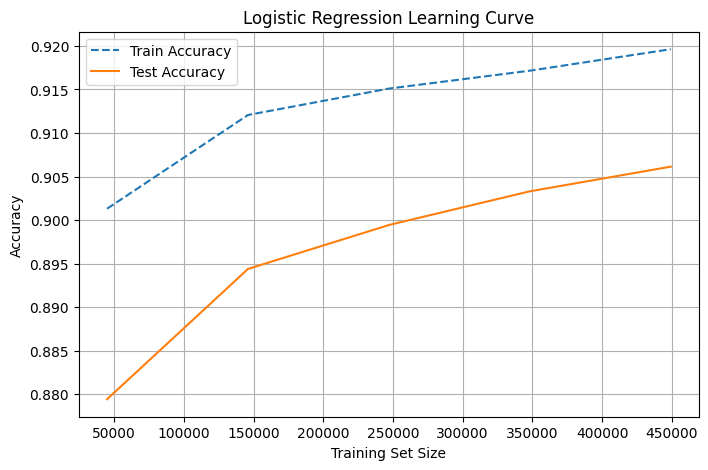

In [15]:
# ==================== Logistic Regression Learning Curve ====================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=2000, n_jobs=-1)

train_sizes, train_scores, test_scores = learning_curve(
    lr_model, X_train_tfidf, y_train,
    cv=3, train_sizes=np.linspace(0.1,1.0,5), n_jobs=-1, scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, '--', label='Train Accuracy')
plt.plot(train_sizes, test_mean, label='Test Accuracy')
plt.title('Logistic Regression Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# ==================== Linear SVM ====================
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

svm_model = LinearSVC(max_iter=2000)
print("Training Linear SVM...")
svm_model.fit(X_train_tfidf, y_train)

y_pred_svm = svm_model.predict(X_test_tfidf)
print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

# Save model
pickle.dump(svm_model, open("/content/linearSVM_hate_model.pkl", "wb"))
print("Linear SVM model saved!")


Training Linear SVM...
Linear SVM Accuracy: 0.9261932604011468
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    141728
           1       0.81      0.71      0.75     26739

    accuracy                           0.93    168467
   macro avg       0.88      0.84      0.85    168467
weighted avg       0.92      0.93      0.92    168467

Confusion Matrix:
 [[137162   4566]
 [  7868  18871]]
Linear SVM model saved!


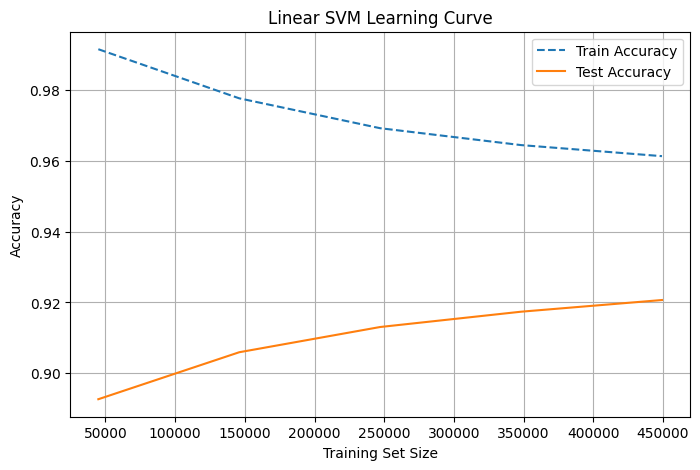

In [18]:
# ==================== Linear SVM Learning Curve ====================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.svm import LinearSVC

svm_model = LinearSVC(max_iter=2000)

train_sizes, train_scores, test_scores = learning_curve(
    svm_model, X_train_tfidf, y_train,
    cv=3, train_sizes=np.linspace(0.1,1.0,5), n_jobs=-1, scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, '--', label='Train Accuracy')
plt.plot(train_sizes, test_mean, label='Test Accuracy')
plt.title('Linear SVM Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# ==================== Model Comparison ====================
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Collect metrics for all models
models = {
    "Logistic Regression": y_pred_lr,
    "Multinomial Naive Bayes": y_pred_nb,
    "Linear SVM": y_pred_svm
}

comparison = []

for name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    comparison.append({
        "Model": name,
        "Accuracy": round(accuracy, 4),
        "F1 Score": round(f1, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4)
    })

# Create a DataFrame for easy visualization
comparison_df = pd.DataFrame(comparison)
comparison_df = comparison_df.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

print("=== Model Comparison ===")
print(comparison_df)


=== Model Comparison ===
                     Model  Accuracy  F1 Score  Precision  Recall
0               Linear SVM    0.9262    0.7522     0.8052  0.7057
1      Logistic Regression    0.9096    0.6651     0.8072  0.5656
2  Multinomial Naive Bayes    0.8957    0.6348     0.7142  0.5713


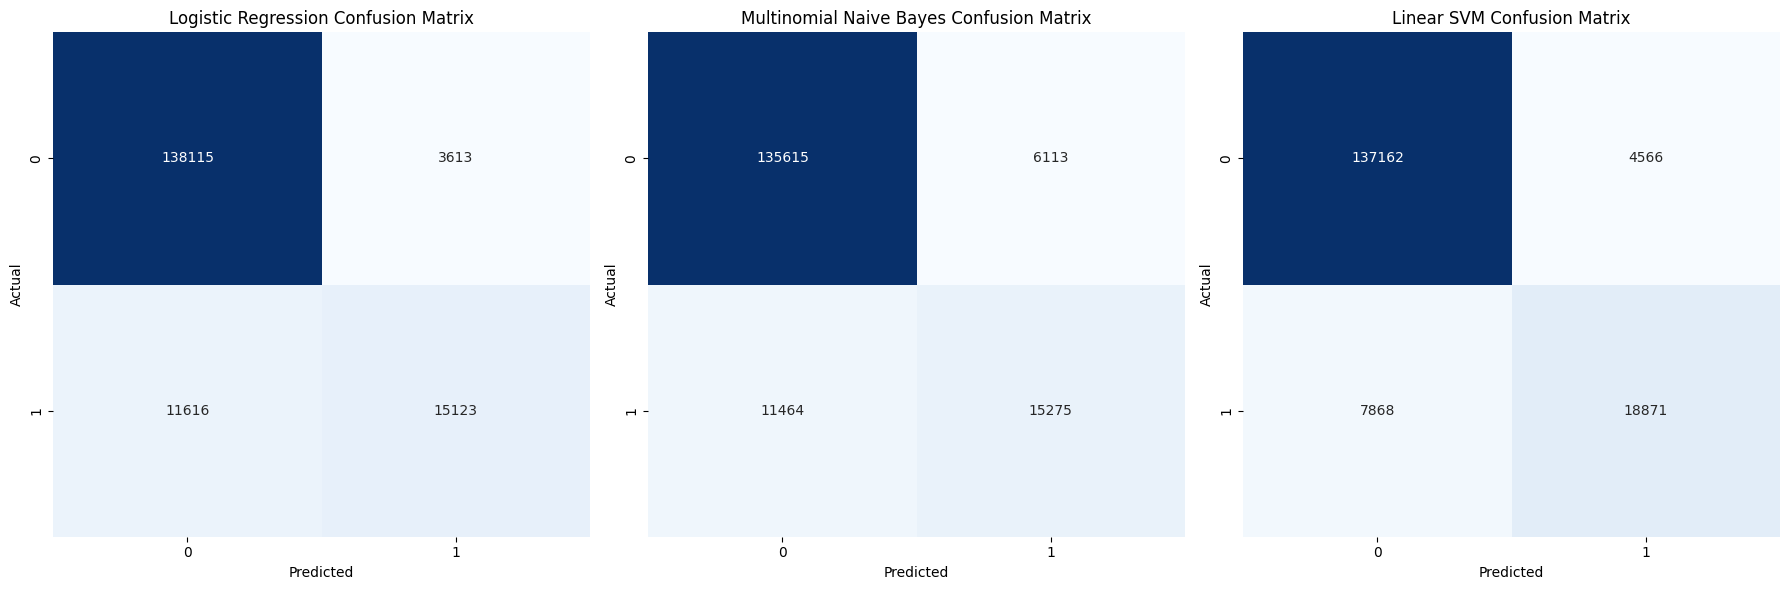

In [35]:
# ==================== Side-by-Side Confusion Matrices ====================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# List of models and predictions
models = {
    "Logistic Regression": y_pred_lr,
    "Multinomial Naive Bayes": y_pred_nb,
    "Linear SVM": y_pred_svm
}

plt.figure(figsize=(18,6))  # Wide figure for 3 plots

for i, (name, y_pred) in enumerate(models.items(), 1):
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(1,3,i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

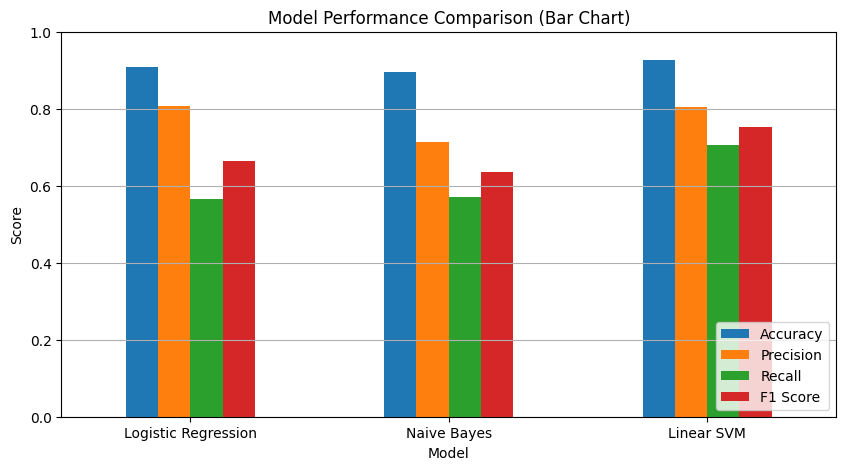

In [43]:
# ==================== Model Performance Comparison — Bar Chart ====================
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Collect metrics
models = {
    "Logistic Regression": y_pred_lr,
    "Naive Bayes": y_pred_nb,
    "Linear SVM": y_pred_svm
}

metrics = []

for name, y_pred in models.items():
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

df_metrics = pd.DataFrame(metrics)

# Plot bar chart
plt.figure(figsize=(10,5))
df_metrics.set_index('Model')[["Accuracy","Precision","Recall","F1 Score"]].plot(kind='bar', rot=0, figsize=(10,5))
plt.title("Model Performance Comparison (Bar Chart)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()


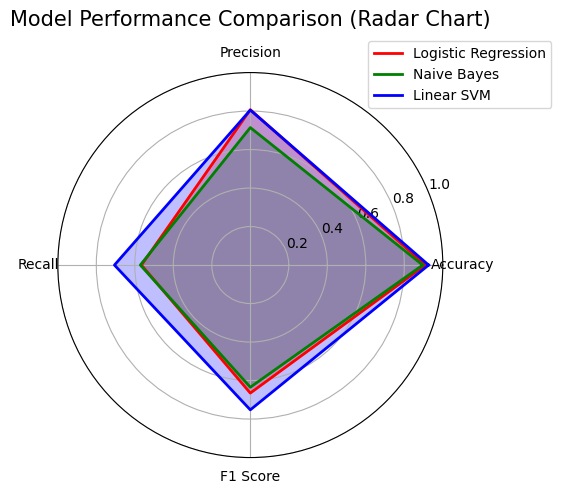

In [46]:
# ==================== Model Performance Comparison — Radar Chart ====================
import matplotlib.pyplot as plt
import numpy as np

labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

plt.figure(figsize=(5,5))
ax = plt.subplot(111, polar=True)

# Plot each model
colors = ['r','g','b']
for i, row in df_metrics.iterrows():
    values = row[labels].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, color=colors[i], linewidth=2, label=row['Model'])
    ax.fill(angles, values, color=colors[i], alpha=0.25)

# Labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(["0.2","0.4","0.6","0.8","1.0"])
plt.title("Model Performance Comparison (Radar Chart)", size=15, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


Logistic Regression training time: 48.09 seconds
Multinomial Naive Bayes training time: 0.58 seconds
Linear SVM training time: 77.75 seconds


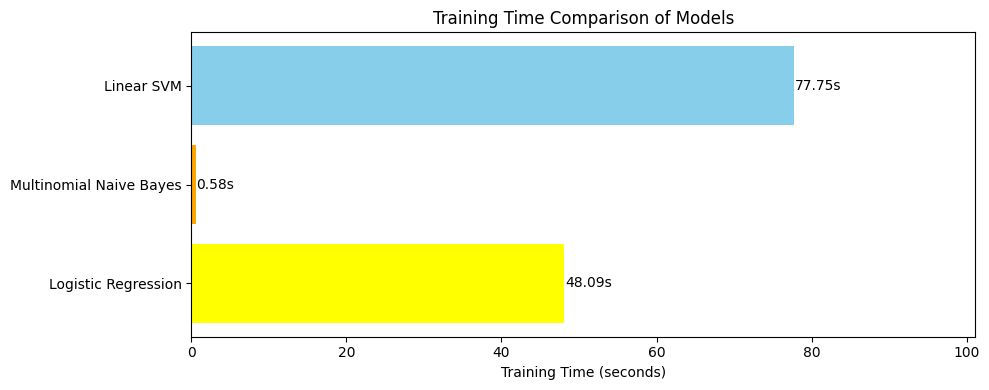

In [48]:
# ==================== Training Time Comparison ====================
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, n_jobs=-1),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(max_iter=2000)
}

train_times = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_tfidf, y_train)
    end_time = time.time()

    elapsed = end_time - start_time
    train_times.append(elapsed)
    print(f"{name} training time: {elapsed:.2f} seconds")

# ---------------- Plotting ----------------
plt.figure(figsize=(10,4))  # smaller figure
bars = plt.barh(list(models.keys()), train_times, color=['yellow','orange','skyblue'])
plt.xlabel("Training Time (seconds)")
plt.title("Training Time Comparison of Models")
plt.xlim(0, max(train_times)*1.3)  # extra space for text

# Add text labels
for bar, t in zip(bars, train_times):
    plt.text(t + 0.1, bar.get_y() + bar.get_height()/2, f"{t:.2f}s", va='center', fontsize=10)

plt.tight_layout()
plt.show()


In [25]:
import pickle
pickle.dump(tfidf, open("/content/tfidf_vectorizer.pkl", "wb"))
print("TF-IDF vectorizer saved as tfidf_vectorizer.pkl")


TF-IDF vectorizer saved as tfidf_vectorizer.pkl


In [51]:
# ==================== Predict New Text Using All Models ====================
import pickle
import re

# Load models & TF-IDF vectorizer if not already in memory
tfidf = pickle.load(open("/content/tfidf_vectorizer.pkl", "rb"))
lr_model = pickle.load(open("/content/logistic_hate_model.pkl", "rb"))
nb_model = pickle.load(open("/content/naivebayes_hate_model.pkl", "rb"))
svm_model = pickle.load(open("/content/linearSVM_hate_model.pkl", "rb"))

# Function to clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)             # remove links
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)    # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()       # remove extra spaces
    return text

# Function to predict
def predict_hate(text):
    clean = clean_text(text)
    vector = tfidf.transform([clean])

    preds = {
        "Logistic Regression": lr_model.predict(vector)[0],
        "Multinomial Naive Bayes": nb_model.predict(vector)[0],
        "Linear SVM": svm_model.predict(vector)[0]
    }

    # Convert 0/1 to labels
    for key in preds:
        preds[key] = "Hate" if preds[key]==1 else "Not Hate"

    return preds

# Example usage
sample_text = "bullshit !"
prediction = predict_hate(sample_text)

print("Input Text:", sample_text)
print("\nModel Predictions:\n")

for model, result in prediction.items():
    print(f"{model}: {result}")



Input Text: bullshit !

Model Predictions:

Logistic Regression: Hate
Multinomial Naive Bayes: Hate
Linear SVM: Hate


In [52]:
# ==================== Gradio Hate Speech Detection (Side-by-Side Output) ====================
!pip install gradio -q

import gradio as gr
import pickle
import re
import numpy as np
from scipy.special import expit  # sigmoid for SVM

# ---- Load Vectorizer + Models ----
tfidf = pickle.load(open("/content/tfidf_vectorizer.pkl", "rb"))
lr_model = pickle.load(open("/content/logistic_hate_model.pkl", "rb"))
nb_model = pickle.load(open("/content/naivebayes_hate_model.pkl", "rb"))
svm_model = pickle.load(open("/content/linearSVM_hate_model.pkl", "rb"))

# ---- Clean Text ----
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

# ---- Prediction Function ----
def predict_with_prob(text):
    clean = clean_text(text)
    vector = tfidf.transform([clean])

    results = {}

    # Logistic Regression
    prob_lr = lr_model.predict_proba(vector)[0]
    pred_lr = lr_model.predict(vector)[0]

    results["Logistic Regression"] = {
        "prediction": "Hate" if pred_lr else "Not Hate",
        "prob_not_hate": round(prob_lr[0],4),
        "prob_hate": round(prob_lr[1],4)
    }

    # Naive Bayes
    prob_nb = nb_model.predict_proba(vector)[0]
    pred_nb = nb_model.predict(vector)[0]

    results["Naive Bayes"] = {
        "prediction": "Hate" if pred_nb else "Not Hate",
        "prob_not_hate": round(prob_nb[0],4),
        "prob_hate": round(prob_nb[1],4)
    }

    # Linear SVM
    decision = svm_model.decision_function(vector)[0]
    prob_hate_svm = float(expit(decision))
    prob_not_hate_svm = 1 - prob_hate_svm
    pred_svm = svm_model.predict(vector)[0]

    results["Linear SVM"] = {
        "prediction": "Hate" if pred_svm else "Not Hate",
        "prob_not_hate": round(prob_not_hate_svm,4),
        "prob_hate": round(prob_hate_svm,4)
    }

    return results


# ---- Gradio Output Formatter (side by side) ----
def gradio_predict(text):
    res = predict_with_prob(text)

    html = """
    <div style='display:flex; gap:20px; width:100%; justify-content:space-evenly;'>
    """

    for model, data in res.items():
        color = "red" if data["prediction"]=="Hate" else "green"

        block = f"""
        <div style='flex:1; padding:15px; border:1px solid #ccc; border-radius:10px;'>
            <h3 style='text-align:center;'>{model}</h3>
            <p><b>Prediction:</b> <span style='color:{color}; font-weight:bold;'>{data["prediction"]}</span></p>
            <p><b>Not Hate:</b> {data["prob_not_hate"]}</p>
            <p><b>Hate:</b> {data["prob_hate"]}</p>
        </div>
        """

        html += block

    html += "</div>"
    return html


# ---- Gradio UI ----
with gr.Blocks() as app:
    gr.Markdown("<h2 style='text-align:center;'>Hate Speech Detection (Side-by-Side Model Output)</h2>")

    text_input = gr.Textbox(
        label="Enter Text",
        placeholder="Type something...",
        lines=4
    )

    btn = gr.Button("Predict")

    output_box = gr.HTML()

    btn.click(fn=gradio_predict, inputs=text_input, outputs=output_box)

app.launch(debug=False, share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2d1b2451c919ac7c55.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
